In [1]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib
import copy

# Check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# Load CSV
df = pd.read_csv("../data/raw/bs_dataset.csv")[:250000]
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   S       250000 non-null  float64
 1   K       250000 non-null  float64
 2   T       250000 non-null  float64
 3   r       250000 non-null  float64
 4   sigma   250000 non-null  float64
 5   type    250000 non-null  int64  
 6   price   250000 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 13.4 MB


,S,K,T,r,sigma,type,price
0,87.454012,145.071431,1.477388,0.059866,0.135810,0,3.236445e-02
1,59.997492,95.924889,0.700732,0.014287,0.407989,0,1.055673e+00
2,146.990985,133.244264,0.464061,0.018182,0.150872,1,1.109715e+00
3,111.165316,50.706631,0.094972,0.052477,0.269924,1,6.970430e-22
4,79.214465,86.636184,0.939336,0.078518,0.159821,0,4.323768e+00


## Basic Data Preprocessing

In [3]:
X = df[["S", "K", "T", "r", "sigma", "type"]].values
y = df["price"].values.reshape(-1, 1)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [5]:
train_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_data = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

## Define Model

In [6]:
class OptionPricingNN(nn.Module):
    def __init__(self, input_dim):
        super(OptionPricingNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

## Training

In [7]:
model = OptionPricingNN(input_dim = 6).to(device) # input_dim = X.shape[1]
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 100

# Early Stopping Setup
patience = 5

In [8]:
def evaluate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [9]:
def train(model, train_loader, val_loader, loss_fn, device):
    best_val_loss = float("inf")
    best_model = None
    counter = 0
    losses_train = []
    losses_val = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)
        losses_train.append(avg_train_loss)

        # Validation
        avg_val_loss = evaluate(model, val_loader, loss_fn, device)
        losses_val.append(avg_val_loss)
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss} | Validation Loss = {avg_val_loss}")

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break
    return best_model, losses_train, losses_val

Epoch 0: Train Loss = 0.01630452185225673 | Validation Loss = 0.0005996901311722877
Epoch 1: Train Loss = 0.00044831775665748867 | Validation Loss = 0.0003380829736630878
Epoch 2: Train Loss = 0.0002814707305980846 | Validation Loss = 0.0002409873551556893
Epoch 3: Train Loss = 0.00022238300963770599 | Validation Loss = 0.00017478553799848618
Epoch 4: Train Loss = 0.00019698198948404753 | Validation Loss = 0.0002035566427003708
Epoch 5: Train Loss = 0.00016652648296090774 | Validation Loss = 0.000170098927096509
Epoch 6: Train Loss = 0.00014752443863311782 | Validation Loss = 8.71977775128108e-05
Epoch 7: Train Loss = 0.00013481168973376043 | Validation Loss = 0.00021736368652247964
Epoch 8: Train Loss = 0.00012344051238847897 | Validation Loss = 8.302722094796986e-05
Epoch 9: Train Loss = 0.0001142756874510087 | Validation Loss = 0.00018678431667614064
Epoch 10: Train Loss = 0.00010857127821363975 | Validation Loss = 5.844653560765102e-05
Epoch 11: Train Loss = 9.969627508777194e-05 |

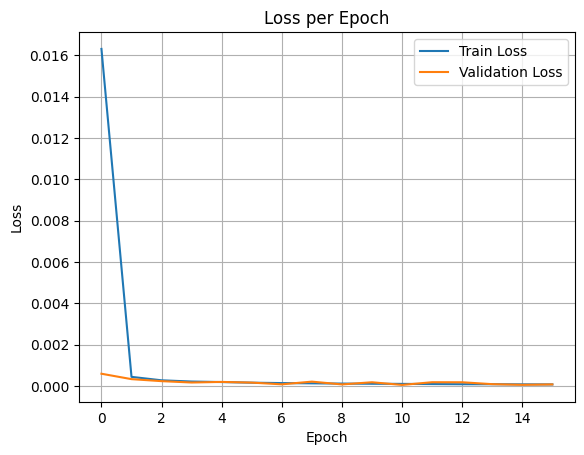

In [10]:
best_model, losses_train, losses_val = train(model, train_loader, val_loader, loss_fn, device)

# Plot Train/Validation Loss
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_val, label="Validation Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Save best Model

In [12]:
model.load_state_dict(best_model)
torch.save(model.state_dict(), "../models/best_model_nn.pt")